# Part 1: Impact Classification

## 1. Load files and combine data

In [1]:
# Import libraries

import nltk
import spacy
nlp = spacy.load('en_core_web_sm')
import pandas as pd
import markdown
import re
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

In [2]:
# Define a function to get and merge REF impact data

def data_merge(star):
    
    # # Load the All REF Results Dataset into a DataFrame
    score_df = pd.read_csv(r"REF-2021-results.csv")
    
    # Filter the dataset to include only 'Impact' profiles with a rating of 100% in the specified column (indicated by 'star')
    impact_score_df = score_df[(score_df['Profile'] == 'Impact') & (score_df[star] == '100')].reset_index(drop = True)
    
    # Remove unnecessary columns
    impact_score_df.drop(columns = ['Multiple submission letter', 'Multiple submission name', 'Joint submission', 'FTE of submitted staff',
                          'Total FTE of submitted staff for joint submission', '% of eligible staff submitted',
                          "Institution sort order", 'Institution name', 'Main panel', 'Unit of assessment name'], inplace = True)
    
    # Rename columns for future merge
    impact_score_df.rename(columns = {'Institution code (UKPRN)' : 'Institution UKPRN code'}, inplace = True)
    
    # Load the Impact Case Study Dataset into a DataFrame
    paper_df = pd.read_csv(r'REF-2021-impactcase.csv')
    
    # Retain nessary columns
    paper_df = paper_df[['Institution UKPRN code', 'Institution name', 'Main panel','Unit of assessment number',
                     'Unit of assessment name', 'Title', '1. Summary of the impact', '2. Underpinning research', 
                     '3. References to the research', '4. Details of the impact', '5. Sources to corroborate the impact']]
    
    # Make sure column names for merging are string type
    impact_score_df['Institution UKPRN code'] = impact_score_df['Institution UKPRN code'].astype('str')
    paper_df['Institution UKPRN code'] = paper_df['Institution UKPRN code'].astype('str')
    
    # Merge 2 dataframes into a new one
    newdf = paper_df.merge(impact_score_df, how = 'inner', on = ['Institution UKPRN code', 'Unit of assessment number']).reset_index(drop = True)
    
    # Keep necessary columns
    newdf = newdf[['Title', '1. Summary of the impact', '4. Details of the impact', star]]
    
    # Update the 'star' column to reflect the rating score
    newdf[star] = star
    
    # Remove asterisk to create a category for each rating score
    newdf[star] = newdf[star].str.replace('*', '', regex=False)
    
    # Rename the 'star' column to 'score'
    newdf = newdf.rename(columns = {star : 'score'})
    
    return newdf

In [3]:
df2 = data_merge('2*') # Get impact case studies with a rating of 2*
df3 = data_merge('3*') # Get impact case studies with a rating of 3*
df4 = data_merge('4*') # Get impact case studies with a rating of 4*

# Check the length of each dataframe
print(len(df2))
print(len(df3))
print(len(df4))

22
108
258


In [4]:
# Combine the DataFrames df2, df3, and df4 into a single DataFrame
df = pd.concat([df2, df3, df4], ignore_index=True)

df

,Title,1. Summary of the impact,4. Details of the impact,score
0,Carnival Cultures: Deepening Understanding and...,### 1. Summary of the impact \(indicative max...,### 4. Details of the impact \(indicative max...,2
1,Naming Adult Autism,### 1. Summary of the impact \(indicative max...,### 4. Details of the impact \(indicative max...,2
2,Changing the Media Narrative and Public Unders...,### 1. Summary of the impact \n\n Professor T...,### 4. Details of the impact \n\n **Kay’s** r...,2
3,Improving rehabilitation and advances in inter...,### 1. Summary of the impact \n\n **Ribbans’*...,### 4. Details of the impact \n\n **Ribbans’*...,2
4,Changing the way that we view video games and ...,# 1. Summary of the impact \n\n Digital media...,# 4. Details of the impact \n\n Etchells’ wor...,2
...,...,...,...,...
383,Transforming the Understanding of Gender in Pr...,### 1. Summary of the impact \n\n Brown has t...,### 4. Details of the impact \n\n Gender\-sen...,4
384,UoP24Athletes: Athletes in extreme environment...,### 1. Summary of the impact \n\n Exercise in...,### 4. Details of the impact \n\n Immersion i...,4
385,UoP24Water: Improving water safety: informing ...,### 1. Summary of the impact \n\n Drowning is...,### 4. Details of the impact \n\n ‘Respect th...,4
386,UoP24Workers: Protecting workers in arduous oc...,### 1. Summary of the impact \n\n Research fr...,### 4. Details of the impact \n\n Following c...,4


## 2. Data Pre-processing

In [5]:
# Check duplicates
duplicates = df[df.duplicated(keep=False)]
duplicates

,Title,1. Summary of the impact,4. Details of the impact,score
183,Augmenting Audio Drama: innovation in the form...,### 1. Summary of the impact \(indicative max...,### 4. Details of the impact \(indicative max...,4
184,Augmenting Audio Drama: innovation in the form...,### 1. Summary of the impact \(indicative max...,### 4. Details of the impact \(indicative max...,4
185,"Dance for Parkinson's: evidencing, developing ...",### 1. Summary of the impact \(indicative max...,### 4. Details of the impact \(indicative max...,4
186,"Dance for Parkinson's: evidencing, developing ...",### 1. Summary of the impact \(indicative max...,### 4. Details of the impact \(indicative max...,4
187,"Dancing with ageing, illness and loss through ...",### 1. Summary of the impact \(indicative max...,### 4. Details of the impact \(indicative max...,4
188,"Dancing with ageing, illness and loss through ...",### 1. Summary of the impact \(indicative max...,### 4. Details of the impact \(indicative max...,4
189,Doing Time,### 1. Summary of the impact \(indicative max...,### 4. Details of the impact \(indicative max...,4
190,Doing Time,### 1. Summary of the impact \(indicative max...,### 4. Details of the impact \(indicative max...,4


In [6]:
# Remove duplicates
df.drop_duplicates(inplace=True)

df = df.reset_index(drop = True)

print(len(df))

384


In [7]:
# Create category

# Update the 'score' column to 0 for rows where the score is '2' or '3'
df.loc[(df['score'] == '2') | (df['score'] == '3'), "score"] = 0

# Update the 'score' column to 1 for rows where the score is '4'
df.loc[df['score'] == '4', "score"] = 1

# Display the first 5 rows
df.head(5)

,Title,1. Summary of the impact,4. Details of the impact,score
0,Carnival Cultures: Deepening Understanding and...,### 1. Summary of the impact \(indicative max...,### 4. Details of the impact \(indicative max...,0
1,Naming Adult Autism,### 1. Summary of the impact \(indicative max...,### 4. Details of the impact \(indicative max...,0
2,Changing the Media Narrative and Public Unders...,### 1. Summary of the impact \n\n Professor T...,### 4. Details of the impact \n\n **Kay’s** r...,0
3,Improving rehabilitation and advances in inter...,### 1. Summary of the impact \n\n **Ribbans’*...,### 4. Details of the impact \n\n **Ribbans’*...,0
4,Changing the way that we view video games and ...,# 1. Summary of the impact \n\n Digital media...,# 4. Details of the impact \n\n Etchells’ wor...,0


In [8]:
# Define a function to clean text by converting Markdown to plain text and removing unnecessary elements

def clean_text(column):
    
    # Import necessary libraries
    from bs4 import BeautifulSoup
    
    import markdown
    
    import re
    
    # Initialize an empty list to store cleaned text
    list_name = []
    
    # Loop through each element in the column
    for i in range(len(column)):
        
        # Converting Markdown syntax into HTML
        html = markdown.markdown(column[i]) 
        
        # Parsing the HTML content to extract plain text
        soup = BeautifulSoup(html, 'html.parser')

        text = soup.get_text()
        
        # Remove reference tags
        text = re.sub(r'\[\d+(?:,\s*\d+)*\]', '', text)
    
        text = re.sub(r'\[\d+(?:,\s*\w+)*\]', '', text)
    
        text = re.sub(r'\[\w+\]', '', text)
        
        # Remove extra newlines (multiple newlines) from the text
        text = re.sub(r'\n+\n*', '', text)
        
        # Remove URLs from the text
        text = re.sub(r'http\S+', '', text)
        
        # Remove specific phrases
        text = text.replace('(indicative maximum 100 words)', "")
            
        text = text.replace('1. Summary of the impact', "")
        
        text = text.replace('(indicative maximum 750 words)', "")
            
        text = text.replace('4. Details of the impact', "")
        
        # Append the cleaned text to the list
        list_name.append(text.strip())
    
    return list_name

In [9]:
# Create a list for the 'Title', Summary of the Impact' and 'Details of the impact' section

summary_list = clean_text(df['1. Summary of the impact'])

detail_list = clean_text(df['4. Details of the impact'])

title_list = clean_text(df['Title'])

In [10]:
from string import punctuation

# Create a list of punctuation characters
punct_list = list(punctuation)

# Append additional characters to the list of punctuation
punct_list.append("")

punct_list.append('’')

punct_list.append('‘')

punct_list.append('”')

punct_list.append('“')

punct_list.append('•')

# Print the updated list of punctuation characters
print(punct_list)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '', '’', '‘', '”', '“', '•']


In [11]:
# Define a function for word tokenization and lemmatization

def word_tokenize(list_name):
    
    # Initialize an empty list to store tokenized text
    list_tokenized = []
    
    # Loop through each text a given list
    for text in list_name:
    
        try:
            # Tokenize and lemmatize the text using the 'nlp' model
            tokens = nlp(text.lower().strip())
            
            # If the number of tokens higher than 1
            if len(tokens) > 1:
                
                # Initialize an empty list to store individual tokens
                token_list = []            
                
                # Loop through all tokens
                for token in tokens:
                    
                    # Get the lemmatized form of the token
                    token_lemma = token.lemma_
                    
                    # Check if token in punct_list
                    if token_lemma not in punct_list:
                    
                        # Remove specific characters
                        token_lemma = token_lemma.replace("/", "") # Rm single backslash
                    
                        token_lemma = token_lemma.replace("-", "") # Rm hyphens
                    
                        token_lemma = token_lemma.replace(".", "") # Rm dots
                        
                        # Append the cleaned token to the list
                        token_list.append(token_lemma.strip())
                
                # Append the list of tokens for the current text to the main list
                list_tokenized.append(token_list)
    
        except Exception as e:
            
            # Print an error message if there's an issue processing the text
            print(f"Error processing text: {text}. Error: {str(e)}")
            
            continue
        
    return list_tokenized

In [12]:
# Tokenize and clean the title text
title_tokenized = word_tokenize(title_list)

# Tokenize and clean the summary text
summary_tokenized = word_tokenize(summary_list)

# Tokenize and clean the details text
detail_tokenized = word_tokenize(detail_list)

In [13]:
# Define a function to join tokens

def word_join(list_name): 
    
    dataset = [] # Initialize an empty list to store joined text

    for text in list_name:
        
        # Join tokens in each list into a single string, separated by spaces
        text_join = " ".join(text)
        
        # Append the joined text to the dataset list
        dataset.append(text_join)
        
    return dataset

In [14]:
# Convert the tokenized texts back into single strings
summary = word_join(summary_tokenized)

detail = word_join(detail_tokenized)

title = word_join(title_tokenized)

In [15]:
# Create a new DataFrame from the title data

newdf = pd.DataFrame(data = title)

# Rename the column to 'title'
newdf.columns = ['title']

# Add the summary text as a new column
newdf['summary'] = summary

# Add the detail text as a new column
newdf['detail'] = detail

# Combine title, summary, and detail into a single column 'paper'
newdf['paper'] = newdf['title'] + " " + newdf['summary'] + " " + newdf['detail']

# Add the score column from the original DataFrame
newdf['score'] = df['score']

# Display the DataFrame
newdf

,title,summary,detail,paper,score
0,carnival culture deepen understanding and insp...,caribbean carnival culture ccc have challenge ...,draw on the insight from her research since 20...,carnival culture deepen understanding and insp...,0
1,name adult autism,base on his experience of an adult diagnosis o...,develop professional awareness b change in pro...,name adult autism base on his experience of an...,0
2,change the medium narrative and public underst...,professor tony kay have contribute to research...,kay ’s research have help to challenge the not...,change the medium narrative and public underst...,0
3,improve rehabilitation and advance in internat...,ribban innovative clinical practice and resear...,ribban research lead to lecture and hand on te...,improve rehabilitation and advance in internat...,0
4,change the way that we view video game and the...,digital medium particularly in the form of soc...,etchell work on video game and screen time hav...,change the way that we view video game and the...,0
...,...,...,...,...,...
379,transform the understanding of gender in preve...,brown have transform policy practice and under...,gender sensitive understanding of prevent and ...,transform the understanding of gender in preve...,1
380,uop24athlete athlete in extreme environment ch...,exercise in extreme environment very cold or h...,immersion in cold water can cause cold shock a...,uop24athlete athlete in extreme environment ch...,1
381,uop24water improve water safety inform interna...,drowning be the third most common cause of acc...,respect the water be a nationwide multimedia w...,uop24water improve water safety inform interna...,1
382,uop24worker protect worker in arduous occupation,research from the university of portsmouth uop...,follow criticism of the size and weight of bod...,uop24worker protect worker in arduous occupati...,1


In [16]:
# Convert paper and score columns to list

paper_data = newdf['paper'].tolist()

score_data = newdf['score'].tolist()

In [17]:
from sklearn.model_selection import train_test_split

# Split into training set and testing set
sample_train, sample_test, score_train, score_test = train_test_split(paper_data, score_data, test_size = 0.2, random_state = 2024)

# Check length of training set and test set
print('Number of training samples:', len(sample_train))
print('\nNumber of testing samples:',len(sample_test))
print('\nTotal number of samples', len(sample_train) + len(sample_test))

Number of training samples: 307

Number of testing samples: 77

Total number of samples 384


## 3. Category Distribution Analysis

/tmp/ipykernel_299642/305017775.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=score_counts.index.astype(str), y=score_counts.values, palette='pastel')


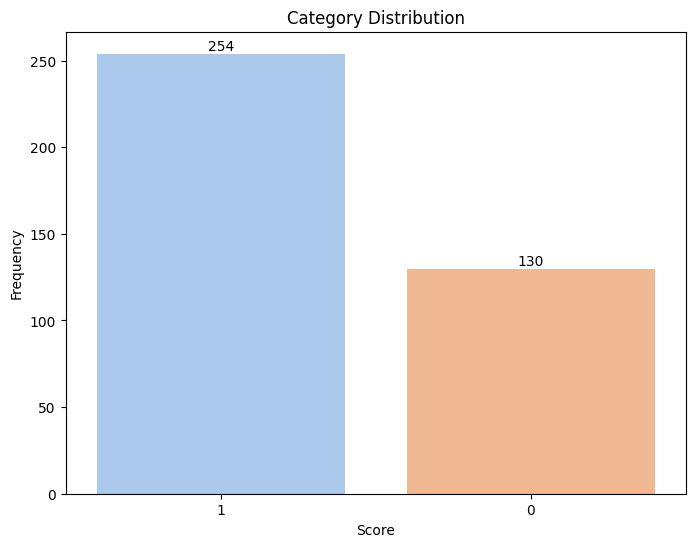

In [18]:
# Category Distribution
import seaborn as sns

# Count occurrences of each score
score_counts = newdf["score"].value_counts()

# Plotting with seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=score_counts.index.astype(str), y=score_counts.values, palette='pastel')

# Add annotations on top of bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

# Adding titles and labels
plt.title('Category Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Display the bar chart
plt.show()
#plt.savefig('category.png')

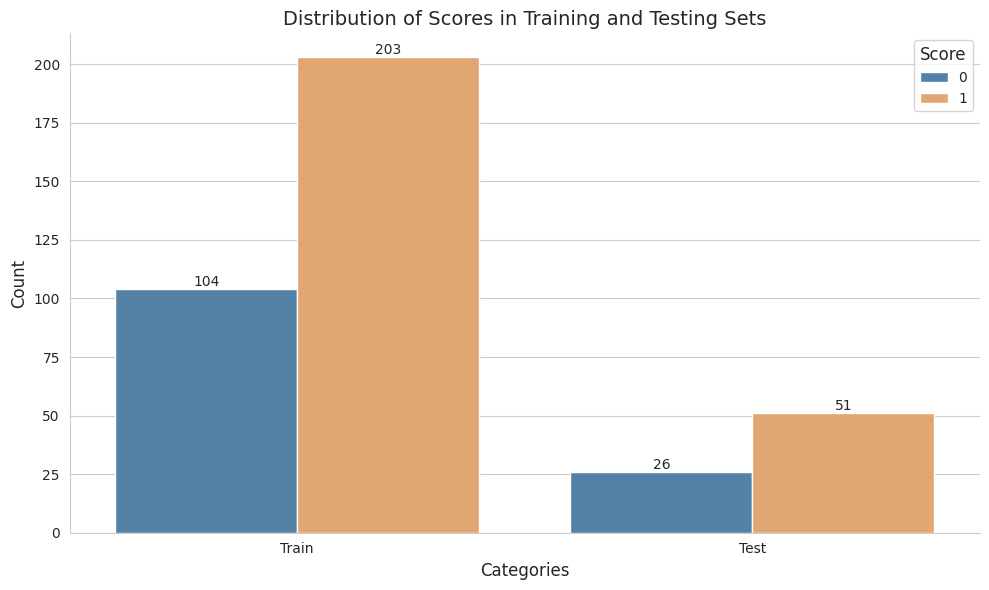

In [19]:
# Category Distribution in Training and Testing Sets

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare the data
categories = ['Train', 'Train', 'Test', 'Test']
scores = ['0', '1', '0', '1']
values = [score_train.count(0), score_train.count(1), score_test.count(0), score_test.count(1)]

# Create a DataFrame
cat_df = pd.DataFrame({'Category': categories, 'Score': scores, 'Count': values})

# Set up the plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the barplot
ax = sns.barplot(x='Category', y='Count', hue='Score', data=cat_df,
                 palette=["steelblue", "sandybrown"])

# Customize the chart
plt.title('Distribution of Scores in Training and Testing Sets', fontsize=14)
plt.xlabel('Categories', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

# Adjust legend
plt.legend(title="Score", title_fontsize='12', fontsize='10')

# Remove top and right spines
sns.despine()

# Display the chart
plt.tight_layout()
plt.show()
#plt.savefig('train-test-category.png')

## 4. Modelling

In [20]:
# Define a function to compute metrics
def get_metrics(real_score, prediction):
    
    # Plot the confusion matrix
    cm = confusion_matrix(real_score, prediction)
    
    plt.figure(figsize = (4,3))
    
    sns.heatmap(cm.T, square = True, annot = True, fmt = 'd', xticklabels=[0,1], yticklabels=[0,1],
           cmap = 'Reds')
    
    plt.xlabel('True Label')
    
    plt.ylabel('Predicted Label')
    
    plt.show()
    
    print("Accuracy:" , accuracy_score(real_score, prediction))
    print("F1-score:" , f1_score(real_score, prediction, average='macro')) # Get average score for all classes
    print("Precision:" , precision_score(real_score, prediction, average='macro')) # Get average score for all classes
    print("Recall:" , recall_score(real_score, prediction, average='macro')) # Get average score for all classes
    print("\nClassification performance:\n" , classification_report(real_score, prediction))

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import RandomOverSampler

# Word Vectorization for sample_train and sample_test
vectorizer = CountVectorizer()

# Fit and transform training data, transform test data
X_train = vectorizer.fit_transform(sample_train)

X_test = vectorizer.transform(sample_test)

# Convert sparse matrix to dense format
X_train_dense = X_train.toarray()

X_test_dense = X_test.toarray()

# OverSampling for X_train
ros = RandomOverSampler(sampling_strategy='minority', random_state=2024)

X_resampled, y_resampled = ros.fit_resample(X_train_dense, score_train)

### Naive Bayes

Cross-validation:

Cross-validation scores: [0.82926829 0.77777778 0.77777778 0.86419753 0.9382716 ]
Mean cross-validation score: 0.8374585968081902

Prediction:

Predicted: [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
Ground truth: [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


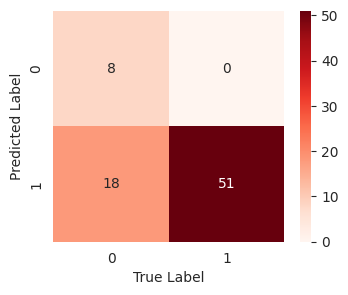

Accuracy: 0.7662337662337663
F1-score: 0.6602941176470588
Precision: 0.8695652173913043
Recall: 0.6538461538461539

Classification performance:
               precision    recall  f1-score   support

           0       1.00      0.31      0.47        26
           1       0.74      1.00      0.85        51

    accuracy                           0.77        77
   macro avg       0.87      0.65      0.66        77
weighted avg       0.83      0.77      0.72        77



In [22]:
# Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

# Initialize the Naive Bayes model
NB_model = MultinomialNB()

# Perform cross-validation
NB_cv_scores = cross_val_score(NB_model, X_resampled, y_resampled, cv=5, scoring='accuracy')

print(f"Cross-validation:\n")
print(f"Cross-validation scores: {NB_cv_scores}")
print(f"Mean cross-validation score: {NB_cv_scores.mean()}")

# Train the model
NB_model.fit(X_resampled, y_resampled)

# Predict
NB_prediction = NB_model.predict(X_test_dense)

print(f"\nPrediction:\n")
print("Predicted:", NB_prediction.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",score_test[0:10])

get_metrics(score_test, NB_prediction)

Overall, these results suggest that your model is performing well both in cross-validation and on the provided test set, with high accuracy and consistency.

### KNN

Cross-validation:

Cross-validation scores: [0.64634146 0.64197531 0.71604938 0.69135802 0.7037037 ]
Mean cross-validation score: 0.6798855766335441

Prediction:

Predicted: [1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Ground truth: [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


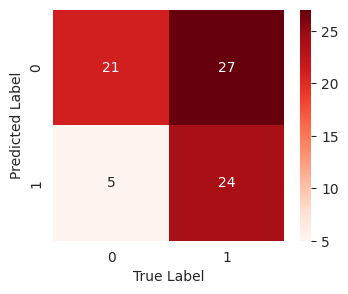

Accuracy: 0.5844155844155844
F1-score: 0.5837837837837838
Precision: 0.6325431034482758
Recall: 0.6391402714932126

Classification performance:
               precision    recall  f1-score   support

           0       0.44      0.81      0.57        26
           1       0.83      0.47      0.60        51

    accuracy                           0.58        77
   macro avg       0.63      0.64      0.58        77
weighted avg       0.70      0.58      0.59        77



In [23]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN model
KNN_model = KNeighborsClassifier(n_neighbors = 2)

# Perform cross-validation
KNN_cv_scores = cross_val_score(KNN_model, X_resampled, y_resampled, cv=5, scoring='accuracy')

print(f"Cross-validation:\n")
print(f"Cross-validation scores: {KNN_cv_scores}")
print(f"Mean cross-validation score: {KNN_cv_scores.mean()}")

# Fit the model
KNN_model.fit(X_resampled, y_resampled)

# Predict
KNN_prediction = KNN_model.predict(X_test_dense)

print(f"\nPrediction:\n")
print("Predicted:", KNN_prediction.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",score_test[0:10])

get_metrics(score_test, KNN_prediction)

### SVM

Cross-validation:

Cross-validation scores: [0.84146341 0.80246914 0.81481481 0.86419753 0.86419753]
Mean cross-validation score: 0.837428485395965

Prediction:

Predicted: [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
Ground truth: [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


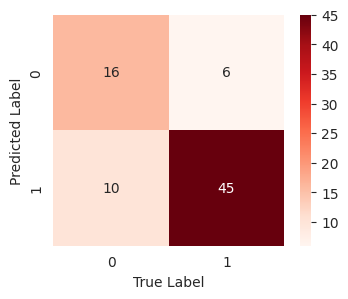

Accuracy: 0.7922077922077922
F1-score: 0.7578616352201257
Precision: 0.7727272727272727
Recall: 0.748868778280543

Classification performance:
               precision    recall  f1-score   support

           0       0.73      0.62      0.67        26
           1       0.82      0.88      0.85        51

    accuracy                           0.79        77
   macro avg       0.77      0.75      0.76        77
weighted avg       0.79      0.79      0.79        77



In [24]:
from sklearn.svm import SVC

# Initialize the SVM model
SVM_model = SVC(kernel='linear')

# Perform cross-validation
SVM_cv_scores = cross_val_score(SVM_model, X_resampled, y_resampled, cv=5, scoring='accuracy')

print(f"Cross-validation:\n")
print(f"Cross-validation scores: {SVM_cv_scores}")
print(f"Mean cross-validation score: {SVM_cv_scores.mean()}")

# Train the model
SVM_model.fit(X_resampled, y_resampled)

# Predict
SVM_prediction = SVM_model.predict(X_test_dense)

print(f"\nPrediction:\n")
print("Predicted:",SVM_prediction.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",score_test[0:10])

get_metrics(score_test, SVM_prediction)

### Decision Tree

Cross-validation:

Cross-validation scores: [0.80487805 0.7654321  0.7654321  0.79012346 0.85185185]
Mean cross-validation score: 0.7955435109906654

Prediction:

Predicted: [1, 1, 1, 1, 1, 0, 1, 1, 1, 1]
Ground truth: [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


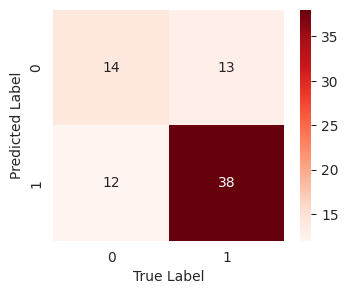

Accuracy: 0.6753246753246753
F1-score: 0.6403885671586027
Precision: 0.6392592592592592
Recall: 0.6417797888386123

Classification performance:
               precision    recall  f1-score   support

           0       0.52      0.54      0.53        26
           1       0.76      0.75      0.75        51

    accuracy                           0.68        77
   macro avg       0.64      0.64      0.64        77
weighted avg       0.68      0.68      0.68        77



In [25]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
DT_model = DecisionTreeClassifier(random_state = 2024)

# Perform cross-validation
DT_cv_scores = cross_val_score(DT_model, X_resampled, y_resampled, cv=5, scoring='accuracy')

print(f"Cross-validation:\n")
print(f"Cross-validation scores: {DT_cv_scores}")
print(f"Mean cross-validation score: {DT_cv_scores.mean()}")

# Train the model
DT_model.fit(X_resampled, y_resampled)

# Predict
DT_prediction = DT_model.predict(X_test_dense)

print(f"\nPrediction:\n")
print("Predicted:",DT_prediction.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",score_test[0:10])

get_metrics(score_test, DT_prediction)

### Random Forest

Cross-validation:

Cross-validation scores: [0.81707317 0.81481481 0.82716049 0.96296296 0.97530864]
Mean cross-validation score: 0.8794640168623908

Prediction:

Predicted: [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
Ground truth: [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


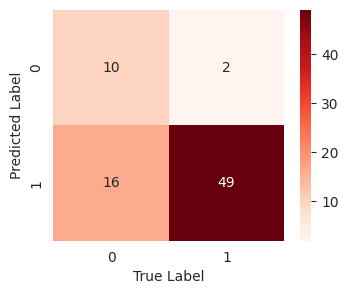

Accuracy: 0.7662337662337663
F1-score: 0.6855716878402903
Precision: 0.7935897435897437
Recall: 0.6726998491704375

Classification performance:
               precision    recall  f1-score   support

           0       0.83      0.38      0.53        26
           1       0.75      0.96      0.84        51

    accuracy                           0.77        77
   macro avg       0.79      0.67      0.69        77
weighted avg       0.78      0.77      0.74        77



In [26]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
RF_model = RandomForestClassifier(n_estimators = 1000, random_state = 2024)

# Perform cross-validation
RF_cv_scores = cross_val_score(RF_model, X_resampled, y_resampled, cv=5, scoring='accuracy')

print(f"Cross-validation:\n")
print(f"Cross-validation scores: {RF_cv_scores}")
print(f"Mean cross-validation score: {RF_cv_scores.mean()}")

# Train the model
RF_model.fit(X_resampled, y_resampled)

# Predict
RF_prediction = RF_model.predict(X_test_dense)

print(f"\nPrediction:\n")
print("Predicted:",RF_prediction.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",score_test[0:10])

get_metrics(score_test, RF_prediction)

### Gradient Boosting Classifier

Cross-validation:

Cross-validation scores: [0.84146341 0.82716049 0.80246914 0.90123457 0.87654321]
Mean cross-validation score: 0.8497741644083108

Prediction:

Predicted: [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
Ground truth: [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


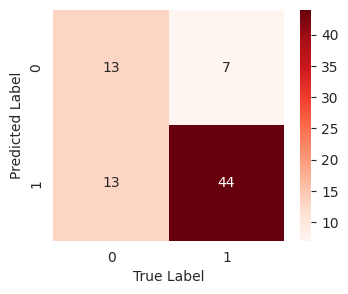

Accuracy: 0.7402597402597403
F1-score: 0.6900161030595814
Precision: 0.7109649122807018
Recall: 0.6813725490196079

Classification performance:
               precision    recall  f1-score   support

           0       0.65      0.50      0.57        26
           1       0.77      0.86      0.81        51

    accuracy                           0.74        77
   macro avg       0.71      0.68      0.69        77
weighted avg       0.73      0.74      0.73        77



In [27]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting Classifier
GBC_model =  GradientBoostingClassifier(n_estimators = 1000, random_state = 2024)

# Perform cross-validation
GBC_cv_scores = cross_val_score(GBC_model, X_resampled, y_resampled, cv=5, scoring='accuracy')

print(f"Cross-validation:\n")
print(f"Cross-validation scores: {GBC_cv_scores}")
print(f"Mean cross-validation score: {GBC_cv_scores.mean()}")

# Train the model
GBC_model.fit(X_resampled, y_resampled)

# Predict
GBC_prediction = GBC_model.predict(X_test_dense)

print(f"\nPrediction:\n")
print("Predicted:",GBC_prediction.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",score_test[0:10])

get_metrics(score_test, GBC_prediction)

### AdaBoost

Cross-validation:

Cross-validation scores: [0.81707317 0.83950617 0.77777778 0.90123457 0.81481481]
Mean cross-validation score: 0.8300813008130081

Prediction:

Predicted: [1, 1, 0, 1, 1, 1, 0, 0, 1, 1]
Ground truth: [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


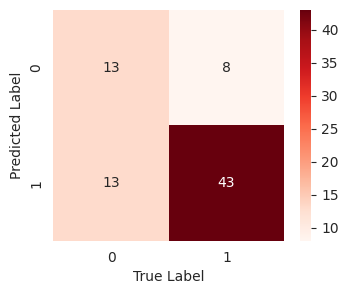

Accuracy: 0.7272727272727273
F1-score: 0.6784649035593557
Precision: 0.6934523809523809
Recall: 0.6715686274509804

Classification performance:
               precision    recall  f1-score   support

           0       0.62      0.50      0.55        26
           1       0.77      0.84      0.80        51

    accuracy                           0.73        77
   macro avg       0.69      0.67      0.68        77
weighted avg       0.72      0.73      0.72        77



In [28]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize the AdaBoost Classifier
ADA_model = AdaBoostClassifier(n_estimators = 1000, random_state = 2024, learning_rate = 0.1)

# Perform cross-validation
ADA_cv_scores = cross_val_score(ADA_model, X_resampled, y_resampled, cv=5, scoring='accuracy')

print(f"Cross-validation:\n")
print(f"Cross-validation scores: {ADA_cv_scores}")
print(f"Mean cross-validation score: {ADA_cv_scores.mean()}")

# Train the model
ADA_model.fit(X_resampled, y_resampled)

# Predict
ADA_prediction = ADA_model.predict(X_test_dense)

print(f"\nPrediction:\n")
print("Predicted:", ADA_prediction.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",score_test[0:10])

get_metrics(score_test, ADA_prediction)

### Extreme Gradient Boosting

Cross-validation:

Cross-validation scores: [0.81707317 0.7654321  0.80246914 0.91358025 0.92592593]
Mean cross-validation score: 0.844896115627823

Prediction:

Predicted: [1, 1, 1, 1, 1, 0, 0, 0, 1, 1]
Ground truth: [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


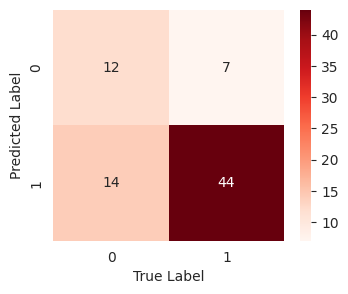

Accuracy: 0.7272727272727273
F1-score: 0.6703363914373088
Precision: 0.6950998185117967
Recall: 0.6621417797888387

Classification performance:
               precision    recall  f1-score   support

           0       0.63      0.46      0.53        26
           1       0.76      0.86      0.81        51

    accuracy                           0.73        77
   macro avg       0.70      0.66      0.67        77
weighted avg       0.72      0.73      0.71        77



In [29]:
from xgboost import XGBClassifier

# Initialize the Extreme Gradient Boosting Classifier
XGB_model = XGBClassifier(n_estimators = 1000, learning_rate = 0.1, random_state = 2024)

# Perform cross-validation
XGB_cv_scores = cross_val_score(XGB_model, X_resampled, y_resampled, cv=5, scoring='accuracy')

print(f"Cross-validation:\n")
print(f"Cross-validation scores: {XGB_cv_scores}")
print(f"Mean cross-validation score: {XGB_cv_scores.mean()}")

# Train the model
XGB_model.fit(X_resampled, y_resampled)

# Predict
XGB_prediction = XGB_model.predict(X_test_dense)

print(f"\nPrediction:\n")
print("Predicted:", XGB_prediction.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",score_test[0:10])

get_metrics(score_test, XGB_prediction)

## 5.  Model Comparison

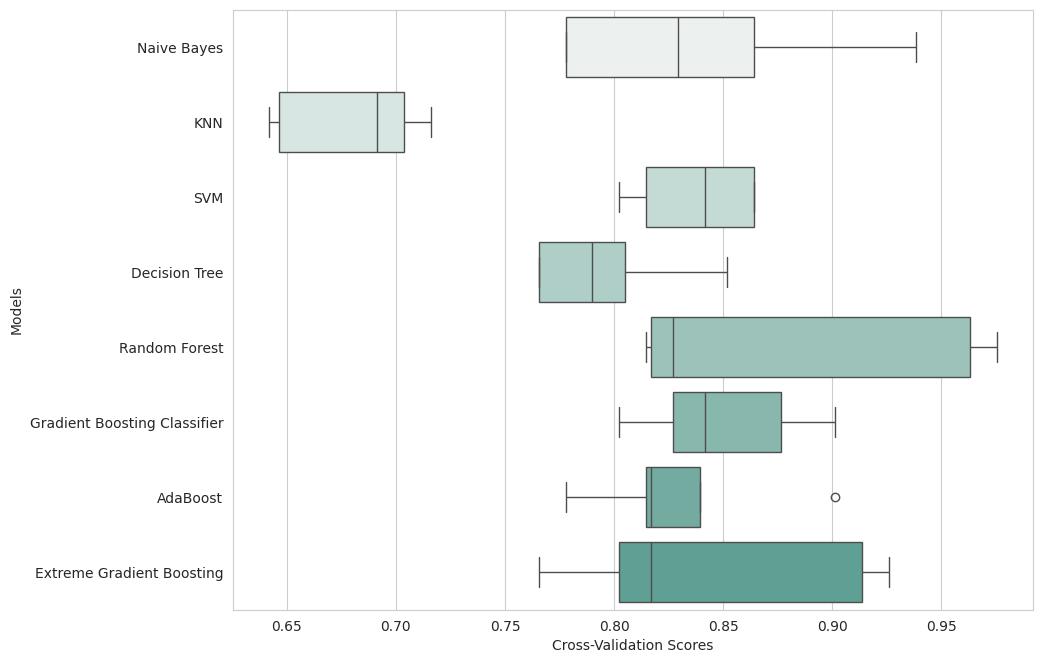

In [30]:
# Create a list to store cross-validation scores
cv_data = [NB_cv_scores, KNN_cv_scores, SVM_cv_scores, DT_cv_scores, RF_cv_scores, GBC_cv_scores, ADA_cv_scores, XGB_cv_scores]

import matplotlib.pyplot as plt
import seaborn as sns

# Create box plot
fig = plt.figure(figsize=(8, 6))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Boxplot
sns.boxplot(data=cv_data, palette='light:#5A9', orient = 'h')

# Set x-axis labels
ax.set_yticks(range(len(['Naive Bayes', 'KNN', 'SVM', 'Decision Tree', 'Random Forest', 'Gradient Boosting Classifier', 
                         'AdaBoost', 'Extreme Gradient Boosting'])))
ax.set_yticklabels(['Naive Bayes', 'KNN', 'SVM', 'Decision Tree', 'Random Forest', 'Gradient Boosting Classifier', 'AdaBoost', 
                    'Extreme Gradient Boosting'])

# Set axis labels
ax.set_xlabel('Cross-Validation Scores')
ax.set_ylabel('Models')

# Show plot
plt.show()

In [31]:
# Create a list to store mean cross-validation scores
cv_mean_data = [NB_cv_scores.mean(), KNN_cv_scores.mean(), SVM_cv_scores.mean(), DT_cv_scores.mean(), 
                RF_cv_scores.mean(), GBC_cv_scores.mean(), ADA_cv_scores.mean(), XGB_cv_scores.mean()]

# Label
model_name = ['Naive Bayes', 'KNN', 'SVM', 'Decision Tree', 'Random Forest', 'Gradient Boosting Classifier', 'AdaBoost', 
                'Extreme Gradient Boosting']

# Create a dataframe to store cross-validation mean score
cv_df = pd.DataFrame(data = model_name)

cv_df['cv_mean'] = cv_mean_data

cv_df.sort_values(by = 'cv_mean', ascending = False)

,0,cv_mean
4,Random Forest,0.879464
5,Gradient Boosting Classifier,0.849774
7,Extreme Gradient Boosting,0.844896
0,Naive Bayes,0.837459
2,SVM,0.837428
6,AdaBoost,0.830081
3,Decision Tree,0.795544
1,KNN,0.679886


# Part 2: Impact Case Study Quality Enhancement

## 1. Get Data

In [32]:
def data_merge_1(star, uoa):
    
    # # Load the All REF Results Dataset into a DataFrame
    score_df = pd.read_csv(r"REF-2021-results.csv")
    
    # Filter the dataset to include only 'Impact' profiles with a rating of 100% in the specified column and UOA = Biological Sciences
    impact_score_df = score_df[(score_df['Profile'] == 'Impact') & 
                               (score_df[star] == '100') &
                                (score_df['Unit of assessment number'] == uoa)].reset_index(drop = True)
    
    # Remove unnecessary columns
    impact_score_df.drop(columns = ['Multiple submission letter', 'Multiple submission name', 'Joint submission', 'FTE of submitted staff',
                          'Total FTE of submitted staff for joint submission', '% of eligible staff submitted',
                          "Institution sort order", 'Institution name', 'Main panel', 'Unit of assessment name'], inplace = True)
    
    # Rename columns for future merge
    impact_score_df.rename(columns = {'Institution code (UKPRN)' : 'Institution UKPRN code'}, inplace = True)
    
    # Load the Impact Case Study Dataset into a DataFrame
    paper_df = pd.read_csv(r'REF-2021-impactcase.csv')
    
    # Retain nessary columns
    paper_df = paper_df[['Institution UKPRN code', 'Institution name', 'Main panel','Unit of assessment number',
                     'Unit of assessment name', 'Title', '1. Summary of the impact', '2. Underpinning research', 
                     '3. References to the research', '4. Details of the impact', '5. Sources to corroborate the impact']]
    
    # Make sure column names for merging are string type
    impact_score_df['Institution UKPRN code'] = impact_score_df['Institution UKPRN code'].astype('str')
    paper_df['Institution UKPRN code'] = paper_df['Institution UKPRN code'].astype('str')
    
    # Merge 2 dataframes into a new one
    newdf = paper_df.merge(impact_score_df, how = 'inner', on = ['Institution UKPRN code', 'Unit of assessment number']).reset_index(drop = True)
    
    # Keep necessary columns
    newdf = newdf[['Institution name','Title', '1. Summary of the impact', '4. Details of the impact', star]]
    
    # Update the 'star' column to reflect the rating score
    newdf[star] = star
    
    # Remove asterisk to create a category for each rating score
    newdf[star] = newdf[star].str.replace('*', '', regex=False)
    
    # Rename the 'star' column to 'score'
    newdf = newdf.rename(columns = {star : 'score'})
    
    return newdf

In [33]:
bio_df1 = data_merge_1('1*', 5)
bio_df2 = data_merge_1('2*', 5) # Get impact case studies with a rating of 2*
bio_df3 = data_merge_1('3*', 5) # Get impact case studies with a rating of 3*
bio_df4 = data_merge_1('4*', 5) # Get impact case studies with a rating of 4*

# Check the length of each dataframe
print(len(bio_df1))
print(len(bio_df2))
print(len(bio_df3))
print(len(bio_df4))

0
2
3
0


In [34]:
# Combine the DataFrames df2 and df3 into a single DataFrame
bio_df = pd.concat([bio_df1, bio_df2, bio_df3], ignore_index=True)

bio_df

,Institution name,Title,1. Summary of the impact,4. Details of the impact,score
0,"University of Northampton, The",Changing the Media Narrative and Public Unders...,### 1. Summary of the impact \n\n Professor T...,### 4. Details of the impact \n\n **Kay’s** r...,2
1,"University of Northampton, The",Improving rehabilitation and advances in inter...,### 1. Summary of the impact \n\n **Ribbans’*...,### 4. Details of the impact \n\n **Ribbans’*...,2
2,University of Glasgow,Commercialisation of a novel microRNA replacem...,1. **Summary of the impact** \n\n Tendinopath...,1. **Details of the impact** \n\n **A novel a...,3
3,University of Glasgow,Deciphering the underlying immunopathology of ...,**1. Summary of the impact** \n\n The autoimmu...,**4. Details of the impact** \n\n **Context** ...,3
4,University of Glasgow,Establishing Caldan Therapeutics Ltd: a spin-o...,**1. Summary of the impact** \n\n A UofG resea...,**4. Details of the impact** \n\n Research at ...,3


In [35]:
# Choose 2 random examples

bio_df.sample(3, random_state=2024)

,Institution name,Title,1. Summary of the impact,4. Details of the impact,score
1,"University of Northampton, The",Improving rehabilitation and advances in inter...,### 1. Summary of the impact \n\n **Ribbans’*...,### 4. Details of the impact \n\n **Ribbans’*...,2
3,University of Glasgow,Deciphering the underlying immunopathology of ...,**1. Summary of the impact** \n\n The autoimmu...,**4. Details of the impact** \n\n **Context** ...,3
4,University of Glasgow,Establishing Caldan Therapeutics Ltd: a spin-o...,**1. Summary of the impact** \n\n A UofG resea...,**4. Details of the impact** \n\n Research at ...,3


In [36]:
# Choose a random 4* sample for one-shot learning

neuro_df4 = data_merge_1('4*', 4)

neuro_df4.sample(1, random_state = 2024)

,Institution name,Title,1. Summary of the impact,4. Details of the impact,score
18,Birkbeck College,The impact of Interpretative Phenomenological ...,### 1. Summary of the impact \(indicative max...,### 4. Details of the impact \(indicative max...,4


## 2. Load new file

In [37]:
claude_df = pd.read_csv('Revised_impact_case_Claude-1.csv')

claude_df

,Title,1. Summary of the impact,4. Details of the impact,score
0,Revolutionizing Ankle Ligament Repair: The Glo...,Professor Ribbans' pioneering clinical practic...,Ribbans' research has had a substantial and wi...,3
1,Deciphering the underlying immunopathology of ...,Guillain–Barré syndrome (GBS) is the most freq...,"Context\nGBS affects 1.1–1.8 people per 100,00...",2
2,Establishing Caldan Therapeutics Ltd: Pioneeri...,Groundbreaking research at the University of G...,The UofG research has generated two significan...,2


## 3. Data Preprocessing

In [38]:
# Category labeling

claude_df.loc[(claude_df['score'] == 2) | (claude_df['score'] == 3), "score"] = 0

claude_df.loc[claude_df['score'] == 4, "score"] = 1

# Display the first 5 rows
claude_df

,Title,1. Summary of the impact,4. Details of the impact,score
0,Revolutionizing Ankle Ligament Repair: The Glo...,Professor Ribbans' pioneering clinical practic...,Ribbans' research has had a substantial and wi...,0
1,Deciphering the underlying immunopathology of ...,Guillain–Barré syndrome (GBS) is the most freq...,"Context\nGBS affects 1.1–1.8 people per 100,00...",0
2,Establishing Caldan Therapeutics Ltd: Pioneeri...,Groundbreaking research at the University of G...,The UofG research has generated two significan...,0


In [39]:
# Using the clean_text function
revised_title_cleaned = clean_text(claude_df['Title'])

revised_summary_cleaned = clean_text(claude_df['1. Summary of the impact'])

revised_detail_cleaned = clean_text(claude_df['4. Details of the impact'])

In [40]:
# Applying the word_tokenize function
revised_title_tokenized = word_tokenize(revised_title_cleaned)

revised_summary_tokenized = word_tokenize(revised_summary_cleaned)

revised_detail_tokenized = word_tokenize(revised_detail_cleaned)

In [41]:
# Applying the word_join function

revised_title = word_join(revised_title_tokenized)

revised_summary = word_join(revised_summary_tokenized)

revised_detail = word_join (revised_detail_tokenized)

In [42]:
# Create a new DataFrame from the revised_title data

revised_df = pd.DataFrame(data = revised_title)

# Rename the column to 'title'
revised_df.columns = ['revised_title']

# Add the summary text as a new column
revised_df['revised_summary'] = revised_summary

# Add the detail text as a new column
revised_df['revised_detail'] = revised_detail

# Combine title, summary, and detail into a single column 'paper'
revised_df['paper'] = revised_df['revised_title']+ " " + revised_df['revised_summary'] + " " + revised_df['revised_detail']

# Add the score column from the original DataFrame
revised_df['score'] = claude_df['score']

# Display the DataFrame
revised_df

,revised_title,revised_summary,revised_detail,paper,score
0,revolutionize ankle ligament repair the global...,professor ribban pioneer clinical practice and...,ribban research have have a substantial and wi...,revolutionize ankle ligament repair the global...,0
1,decipher the underlie immunopathology of guill...,guillain – barré syndrome gbs be the most freq...,"contextgbs affect 11–18 people per 100,000 ann...",decipher the underlie immunopathology of guill...,0
2,establish caldan therapeutics ltd pioneer free...,groundbreake research at the university of gla...,the uofg research have generate two significan...,establish caldan therapeutics ltd pioneer free...,0


In [43]:
# Convert to list
revised_paper_data = revised_df['paper'].tolist()

revised_score_data = revised_df['score'].tolist()

In [44]:
# Vectorization
revised_X_test = vectorizer.transform(revised_paper_data)

revised_X_test_dense = revised_X_test.toarray()

## 4. SVM Model Prediction

In [45]:
SVM_revised_prediction = SVM_model.predict(revised_X_test_dense)

print(f"\nPrediction:\n")
print("Predicted:",SVM_revised_prediction.tolist()) # Print the first 10 predictions
print("Ground truth:",revised_score_data)


Prediction:

Predicted: [0, 0, 0]
Ground truth: [0, 0, 0]
